# Fish Weight Prediction: Multiple Linear Regression

## 1. Introduction
Regression analysis is a common statistical method used in diverse fields. Linear regression is one of the most common techniques of regression analysis. Multiple linear regression (MLR), also known simply as multiple regression, is a statistical technique that uses several explanatory variables to predict the outcome of a response variable. The goal of multiple linear regression is to model the linear relationship between the explanatory (independent) variables and response (dependent) variable.

In this project, we will analyze the fish market dataset and perform multiple linear regression to prediect the weight of the fish. After exploratory data analysis and fitting the initial model, we make several adjustment to the model and obtain our best model, which we used for final testing and predictions. The analysis of the results is included in the third section, along with the models and we also display our final conclusion in the end of this report.

## 2. Exploratory Data Analysis

The dataset we are using contains information on the seven common different species in fish market sales (link to the dataset: https://www.kaggle.com/aungpyaeap/fish-market). The dataset recorded the species name, weight, veritical length (recorded as Length 1), diagonal length (recorded as Length2) and cross length (recorded as Length3) as well as height and width of each one of the fish. We will firstly do some exploratory data analysis to take a look at the dataset's different properties before we decide on a model.

In [7]:
# import python libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# data overview
data=pd.read_csv('fish.csv')
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [10]:
# basic info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [11]:
# check to see if the data has any NaN/null values
data.isnull().values.any()

False

As is shown in the above, this dataset is a pretty small dataset, it only has 7 columns and 159 entries in total. Apart from the column "Species", other columns all have type float and all lengths, height and width is measure in cm. In addition, this dataset does not include any none/null values. Next, we will look into the data's more features in details.

In [12]:
# basic statistical features of the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20837bd0>,
      dtype=object)

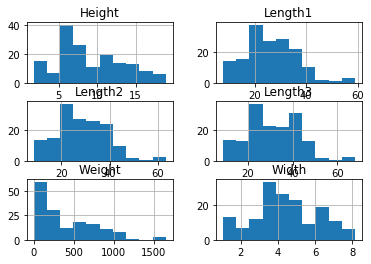

In [13]:
# histogram of shape information
data.hist()

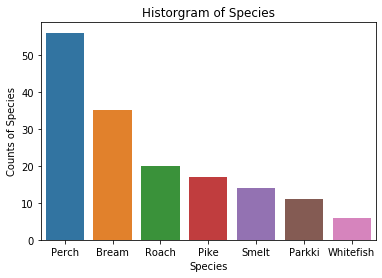

In [14]:
# histogram of species
sp = data['Species'].value_counts()
sp = pd.DataFrame(sp)
sns.barplot(x=sp.index, y=sp['Species']);
plt.xlabel('Species')
plt.ylabel('Counts of Species')
plt.title('Historgram of Species')
plt.show()

As is shown in the figures above, we did not observe very unusual situations among the distribution of different variables in the dataset. However, we might notice that some species of fish are of very small quantities in the dataset. For example, Whitefish has less than 10 entries. In that case, it could be hard for us to do certain models because the size of the data is too small.

In [52]:
# check to see the correlations between the attributes of this dataset
data.corr()

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.915712,0.918618,0.923044,0.724345,0.886507
Length1,0.915712,1.000000,0.999517,0.992031,0.625378,0.867050
Length2,0.918618,0.999517,1.000000,0.994103,0.640441,0.873547
Length3,0.923044,0.992031,0.994103,1.000000,0.703409,0.878520
Height,0.724345,0.625378,0.640441,0.703409,1.000000,0.792881
Width,0.886507,0.867050,0.873547,0.878520,0.792881,1.000000


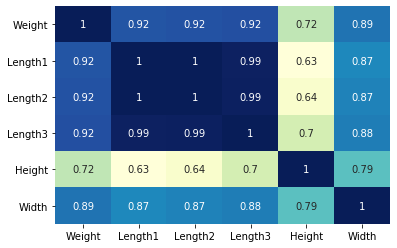

In [53]:
# the heatmap displaying the correlations
sns.heatmap(data.corr(), annot=True,cbar=False,cmap="YlGnBu");

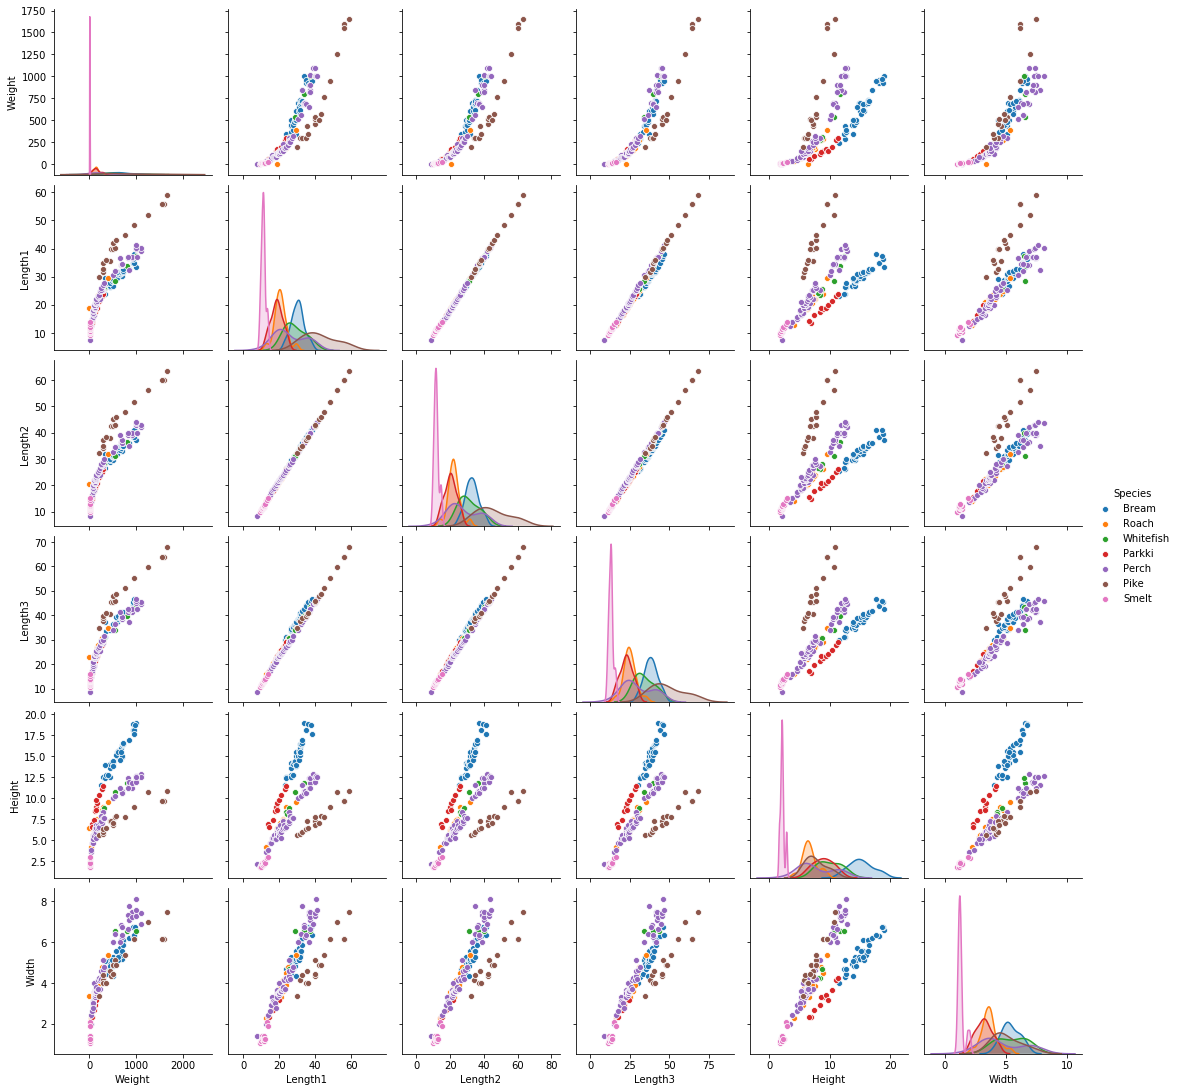

In [54]:
g = sns.pairplot(data, kind='scatter', hue='Species');

The above graphs and chart display the correlation/relevance between different columns in the dataset. As a results, the columns are very correlated with one another: as is reflected in the correlation score chart and the heatmap, all columns has a score over 0.6 with another column in the dataset. And as the pairplot shows, all pairs of columns are positively correlated, though it also dependents on species since we can tell that different colors of dots have slightly different trends on the pairplot. What is also worth mentioning is that the lengths (Length1, Length2, Length3) are highly correlated. Each two of them have a correlation over 0.99, which also makes their pairplot nearly a straight line.

In [55]:
# VIF score
datai = data.drop('Species',axis='columns')
datav = datai.to_numpy()
vif = [variance_inflation_factor(datav, i) for i in range(datav.shape[1])]
for i in range(6):
    print("VIF of " + datai.columns[i] + ": " + str(vif[i]))

VIF of Weight: 6.832972727886178
VIF of Length1: 13551.449805334765
VIF of Length2: 16775.194677808628
VIF of Length3: 3561.9126190101833
VIF of Height: 83.40218622375696
VIF of Width: 94.0529334212187


The VIF scores are calculated in the above. As the results show, most of the VIF scores are actually very high, which indicates high multicollinearity.

## 3. Machine Learning Model Implementation

### Learning Task: Predicting the Weight of the Fish
After discussion, we have chosen the learning task to be predicting the weight of the fish with length, height and width. We have chosen weight to predict because weight is the only column (besides species) that does not measures shape. The other columns measure shape with length in different parts of a fish, and so intuitivity we think that it makes sense to use the information about the shape to prediect the weight.

### Model: Multiple Linear Regression
We've decided to use regression for this learning task on prediecting the weight of the fish because as is shown in the data analysis section above, the data has displayed strong correlation between different colunmns. Also, since more than 1 column has shown strong connection with weight, we will do a multiple linear regression. We choose regression over classification because weight is a numerical value, instead of a discrete "label". 

----
### Model 1: general case
We will first do a model to predict the weight with length1, 2 and 3 as well as height and width:


In [15]:
# add a constant column to make the ols work
data['constant']=[1]*159
# target variable: weight
y = data['Weight']
# independent variable set: everything besides species and weight
X = data.iloc[:,2:8]

In [16]:
# split traning and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# fitting the data with train data
ols = sm.OLS(y_train, X_train)
model = ols.fit()
# print the result summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     188.4
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           2.42e-55
Time:                        20:40:55   Log-Likelihood:                -787.32
No. Observations:                 127   AIC:                             1587.
Df Residuals:                     121   BIC:                             1604.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length1       56.9059     44.689      1.273      0.2

As is shown in the fitting results, the accuracy/R-squared number is 0.886, which is a decent result. However, the p-values of some columns are not very satisfying since they are over 0.05. We will try adjust the model to improve the overall performance.

----
### Model 2: Prediction with Different Species
It is obvious that in the previous model, we've been leaving out an important variable in our analysis: the species. It is definitely an important variable, and we can also observe its importance by the pairplot in the analysis section above. Therefore, we will separate these data into different groups based on their species, and fit each group with OLS models to see whether it produces more satisfying results.

In [17]:
# group 1: Bream
data_bream = data.loc[data['Species']=='Bream']
y_bream = data_bream['Weight']
X_bream = data_bream.iloc[:,2:8]
X_bream_train, X_bream_test, y_bream_train, y_bream_test = train_test_split(X_bream, y_bream, test_size=0.2, random_state=1)
ols = sm.OLS(y_bream_train, X_bream_train)
model_bream = ols.fit()
print(model_bream.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     62.76
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           2.81e-12
Time:                        20:41:27   Log-Likelihood:                -149.35
No. Observations:                  28   AIC:                             310.7
Df Residuals:                      22   BIC:                             318.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length1      -15.4211     60.272     -0.256      0.8

In [18]:
# group 2: Perch
data_perch = data.loc[data['Species']=='Perch']
y_perch = data_perch['Weight']
X_perch = data_perch.iloc[:,2:8]
X_perch_train, X_perch_test, y_perch_train, y_perch_test = train_test_split(X_perch, y_perch, test_size=0.2, random_state=1)
ols = sm.OLS(y_perch_train, X_perch_train)
model_perch = ols.fit()
print(model_perch.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     106.4
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           2.80e-21
Time:                        20:41:35   Log-Likelihood:                -258.36
No. Observations:                  44   AIC:                             528.7
Df Residuals:                      38   BIC:                             539.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length1       -3.9968     67.583     -0.059      0.9

After we sort the data into different subgroups based on species, the R-squared value is improved greatly. However, the p-value problems have not yet been solved. In addition, the OLS method failed to produce convincing results for other species because they all have less than 20 entries (errors were displayed when we try to execute) so we will not contain those processes in this report.

To conclude, sorting the data based on different species will help improve the accuracy of the model, but it is hard to fully apply this variable since the size of the data is too small for some species.

----

### Model 3: Dropping selected columns

As is shown in the analysis section, the length variables (Length1, Length2, Length3) are highly correlated. Therefore, we will try dropping one or two columns from them because their similarity might make the regression unstable.

In [19]:
# model3a: drop 1 column
data1 = data.drop('Length3',axis='columns')
y1 = data1['Weight']
X1 = data1.iloc[:,2:7]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)
model1 = sm.OLS(y1_train, X1_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     232.2
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           4.93e-56
Time:                        20:41:45   Log-Likelihood:                -788.59
No. Observations:                 127   AIC:                             1587.
Df Residuals:                     122   BIC:                             1601.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length1       57.6212     44.948      1.282      0.2

In [20]:
# model 3b: dropping two columns
data2 = data.drop('Length2',axis='columns').drop('Length3',axis='columns')
y2 = data2['Weight']
X2 = data2.iloc[:,2:6]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1)
model2 = sm.OLS(y2_train, X2_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     310.1
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           3.67e-57
Time:                        20:41:58   Log-Likelihood:                -788.96
No. Observations:                 127   AIC:                             1586.
Df Residuals:                     123   BIC:                             1597.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Length1       19.6895      2.163      9.102      0.0

As is indicated in the results, the R-squared value was not imporved by dropping columns. However, the p-value of the length columns has been greatly improved.

---

### Model 4: Adding in product column

Next, we will try replace the height and width column by their product because the product is the approximately size of the fish, and we think it could be of good relevance with the weight. Also by this replacement, we are reducing the number of variables in our regression.

In [22]:
data['Height*Weight']=data['Height']*data['Weight']
datap = data.drop('Height',axis='columns').drop('Width',axis='columns')
yp = datap['Weight']
Xp = datap.iloc[:,2:7]
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2, random_state=1)
modelp = sm.OLS(yp_train, Xp_train).fit()
print(modelp.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1435.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          1.59e-101
Time:                        20:42:36   Log-Likelihood:                -679.44
No. Observations:                 127   AIC:                             1369.
Df Residuals:                     122   BIC:                             1383.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1          43.4880     17.503      2.485

This adjustment to the model has given us pretty satisfying results: the R-squared value is very closed to 1, and except for Length2, all other columns' p-value is smaller than 0.05.

---
### Model 5: Exploration on model combination
We will now try to combine some of the adjustments above.

In [23]:
# model 5a: model 4 + model 2
datapb = datap.loc[data['Species']=='Bream']
ypb = datapb['Weight']
Xpb = datapb.iloc[:,2:7]
Xpb_train, Xpb_test, ypb_train, ypb_test = train_test_split(Xpb, ypb, test_size=0.2, random_state=1)
modelpb = sm.OLS(ypb_train, Xpb_train).fit()
print(modelpb.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     408.2
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           5.41e-21
Time:                        20:43:17   Log-Likelihood:                -127.64
No. Observations:                  28   AIC:                             265.3
Df Residuals:                      23   BIC:                             271.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1          18.8424     21.847      0.862

In this model, the accuracy is very high but the p-value of length variables remain unsatisfying. Since our previous tryout shows that dropping columns are helpful for reducing p-values, we will also combine that.

In [27]:
# model 5b: drop a column from 5a
dataf = datap.loc[data['Species']=='Bream'].drop('Length2',axis='columns')
yf = dataf['Weight']
Xf = dataf.iloc[:,2:6]
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.2, random_state=1)
modelf = sm.OLS(yf_train, Xf_train).fit()
print(modelf.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     539.5
Date:                Sun, 29 Nov 2020   Prob (F-statistic):           3.79e-22
Time:                        20:44:10   Log-Likelihood:                -128.35
No. Observations:                  28   AIC:                             264.7
Df Residuals:                      24   BIC:                             270.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1           3.8242     17.029      0.225

As is indicated in the summary, the p-value between even larger. Given consideration that the species variable in this dataset is particularly hard to apply, we will try applying the settings to the whole dataset instead to one particular species.

In [28]:
# model 5c: use 5b's setting for all data
datafc = datap.drop('Length2',axis='columns')
yfc = datafc['Weight']
Xfc = datafc.iloc[:,2:6]
Xfc_train, Xfc_test, yfc_train, yfc_test = train_test_split(Xfc, yfc, test_size=0.2, random_state=1)
modelfc = sm.OLS(yfc_train, Xfc_train).fit()
print(modelfc.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1928.
Date:                Sun, 29 Nov 2020   Prob (F-statistic):          3.45e-103
Time:                        20:46:01   Log-Likelihood:                -679.48
No. Observations:                 127   AIC:                             1367.
Df Residuals:                     123   BIC:                             1378.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Length1          48.1292      3.907     12.318

This final method we used is pretty satisfying: the R-squared value is large and the p-values are very small. We will select this as out best model and use it for prediction.

---

### Testing and Making Predictions

In [29]:
# make predidctions with test data
y_pre = modelfc.predict(Xfc_test)
# print out estimation and the actual data
df1 = pd.DataFrame(y_pre,columns=['Estimated Weight']).reset_index(drop=True)
df2 = pd.DataFrame(yfc_test).reset_index(drop=True)
df = pd.concat([df1, df2], axis=1)
df.head()

,Estimated Weight,Weight
0,1114.297752,1000.0
1,104.104609,120.0
2,581.526410,600.0
3,149.123513,130.0
4,114.936419,85.0


In [30]:
# r2 value
print(r2_score(yfc_test, y_pre))

0.9767658766335986


The R-squared between actual data and the estimated values is 0.977, which is very close to 1. This has shown that our model is very satisfying. Next, we will do some visualizations to display the test results.

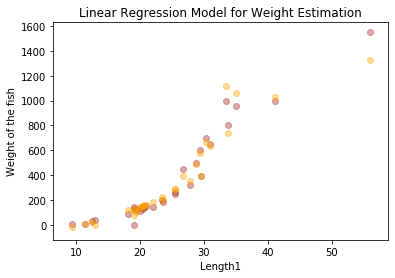

In [31]:
plt.scatter(Xfc_test['Length1'], yfc_test, color='brown', alpha=0.4)
plt.scatter(Xfc_test['Length1'], y_pre, color='orange', alpha=0.4)
plt.xlabel('Length1')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

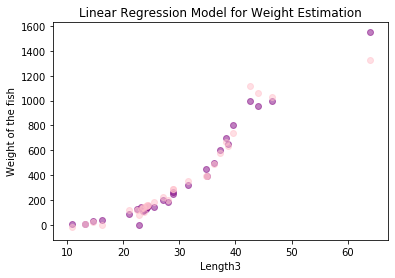

In [32]:
plt.scatter(Xfc_test['Length3'], yfc_test, color='purple', alpha=0.5)
plt.scatter(Xfc_test['Length3'], y_pre, color='pink', alpha=0.5)
plt.xlabel('Length3')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

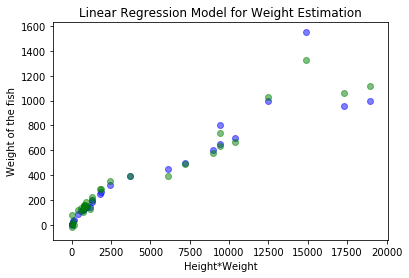

In [33]:
plt.scatter(Xfc_test['Height*Weight'], yfc_test, color='blue', alpha=0.5)
plt.scatter(Xfc_test['Height*Weight'], y_pre, color='green', alpha=0.5)
plt.xlabel('Height*Weight')
plt.ylabel('Weight of the fish')
plt.title('Linear Regression Model for Weight Estimation');

As is also displayed in the visualization for the testing results, our best model's performance is very satisfying.

---

## 4. Conclusion

In this project, we use multiple linear regression model to predict the weight of the fish. After some data analysis, we firstly try a general case and then explore different adjustments on the original model, including sorting dataset based on species, dropping columns and replace columns by product. In the end, we come up with out best model and use for testing and prediction. The best model uses Length1, Length3 and the product of height and weight as variables and perform pretty well during testing.